In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import copy
import matplotlib.pyplot as plt

In [2]:
from Gan import Discriminator, Generator, generate_random_image, generate_random_one_hot, generate_random_seed 

In [3]:
# check CUDA is available

if torch.cuda.is_available():

    torch.set_default_tensor_type(torch.cuda.FloatTensor)# Using GPU to train

    print("Training cuda:", torch.cuda.get_device_name(0))
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training cuda: NVIDIA GeForce GTX 1050 Ti


## Data preparation

In [4]:
#load data
data=[]
data_test=[]

#magnetization for original data
M_raw = []
M_raw_test = []

#there are 500 samples for each temperature, set 400 train data 100 test data

with h5py.File('MC_2layers_T_boundarycondition.hdf5', 'r') as f:

    for i in np.arange(1,51):   
    
        dataset=f[str(i)+'.0K']
    
        data.append(dataset[:][:400])
        
        data_test.append(dataset[:][400:500])

        M_raw.append(dataset[:].mean(axis=0).sum()/100)
        M_raw_test.append(dataset[:][400:500].mean(axis=0).sum()/100)

        
M_raw=np.array(M_raw)
M_raw_test=np.array(M_raw_test)
data=np.array(data)
data_test=np.array(data_test)

data=data.reshape(-1,2,10,10)
data_test=data_test.reshape(-1,2,10,10)

print('Train data shape {}'.format(data.shape))
print('Test data shape {}'.format(data_test.shape))

Train data shape (20000, 2, 10, 10)
Test data shape (5000, 2, 10, 10)


Temperature: 30 K
The two layers magnetization are [0.04010331 0.02324202] respectively


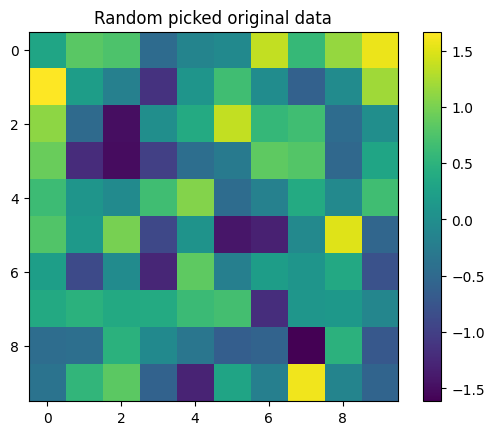

In [15]:
ii=np.random.randint(0,len(data))
print('Temperature: {} K'.format(int(ii/400)+1))
#original data plotting
plt.imshow(data[ii].sum(axis=0))#.cpu().detach().numpy()
plt.title('Random picked original data')
plt.colorbar()
print('The two layers magnetization are {} respectively'.format(data[ii].reshape(2,-1).sum(axis=1)/100))

In [21]:
data_num = 50
T = np.linspace(1,50,data_num)

#One hot encoding
One_hot_code=[]
for i in range(len(T)):
    for j in range(400):
        code=np.zeros(len(T))
        code[i]=1
        One_hot_code.append(code)
One_hot_code=np.array(One_hot_code)

#Transform the train data into [0,1],turn into tensor
data_set=(data+1)/2
data_set=torch.tensor(data_set).to(torch.float32)

#Transform the test data into [0,1],turn into tensor
data_test_set=(data_test+1)/2
data_test_set=torch.tensor(data_test_set).to(torch.float32)

#Transform the one hot coding to tensor
One_hot_code=torch.tensor(One_hot_code).to(torch.float32)

print(data_set.shape)
print(data_test_set.shape)
print(One_hot_code.shape)

#Consolidate data and One hot coding
data_all=[]
for i in range(20000):
    data_all.append([data_set[i], One_hot_code[i]])

torch.Size([20000, 2, 10, 10])
torch.Size([5000, 2, 10, 10])
torch.Size([20000, 50])


In [51]:
batch_size=250

data_loader = torch.utils.data.DataLoader(dataset=data_all,
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          generator=torch.Generator(device = 'cuda'))

## Train Discriminator

In [52]:
%%time
epochs=400
v_dim = 2*10*10
z_dim = 100
h_dim=500
learning_rate=1e-4
class_num=len(T)

model_D = Discriminator(v_dim=v_dim,  h_dim=h_dim, z_dim=z_dim, learning_rate=learning_rate, class_num=class_num)
# move model to cuda device
model_D.to(device)


losses = []

for epoch in np.arange(epochs):

    train_loss=0 
    

    for image_data, label_tensor in data_loader:

        image_data = image_data#.to(device)

        label_tensor = label_tensor#.to(device)
        
        # real_imgs = torch.flatten(image_data)#, start_dim=1
        real_imgs = image_data.view(-1,v_dim)

        # train real data
        model_D.train(real_imgs, label_tensor, torch.ones(batch_size,1))#torch.cuda.FloatTensor([1.0])
        train_loss += model_D.Loss.detach().item()

        # train fake data
        model_D.train(generate_random_image(batch_size,v_dim), generate_random_one_hot(batch_size, class_num),torch.zeros(batch_size,1))#torch.cuda.FloatTensor([0.0])
        train_loss += model_D.Loss.detach().item()
    
    if (epoch+1)%20==0:
        print('Epoch: {}, loss: {}'.format(epoch+1, train_loss / (2*len(data_loader))))

    losses.append(train_loss / (2*len(data_loader)))

Epoch: 20, loss: 0.1470069562084973
Epoch: 40, loss: 0.047313285944983366
Epoch: 60, loss: 0.02369548470014706
Epoch: 80, loss: 0.018387297249864785
Epoch: 100, loss: 0.012208501376881032
Epoch: 120, loss: 0.014234192739604624
Epoch: 140, loss: 0.008984074346699344
Epoch: 160, loss: 0.00943409457031521
Epoch: 180, loss: 0.007272396094617761
Epoch: 200, loss: 0.0072759214014695315
Epoch: 220, loss: 0.005351250311468903
Epoch: 240, loss: 0.00558655253280449
Epoch: 260, loss: 0.006730711685759161
Epoch: 280, loss: 0.004636515752144988
Epoch: 300, loss: 0.008351832738583198
Epoch: 320, loss: 0.0043901900197397484
Epoch: 340, loss: 0.004846788691560277
Epoch: 360, loss: 0.005081465431550214
Epoch: 380, loss: 0.004608100523822145
Epoch: 400, loss: 0.005488465110428819
Wall time: 18min 44s


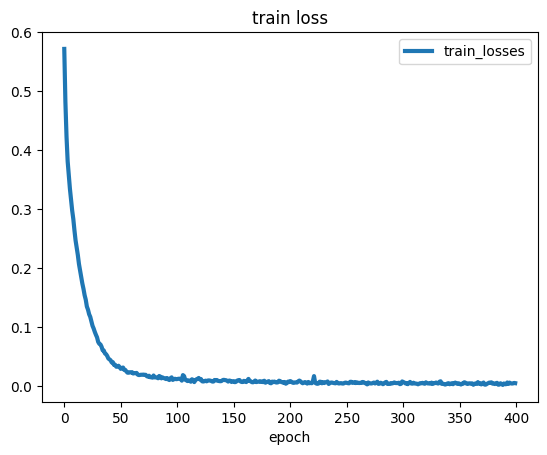

In [54]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses, linewidth=3, linestyle='-', label='train_losses')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [61]:
# test discriminator to distinguish real and fake data
print('True')
for i in range(5): 
    A_label = np.random.randint(0,5000)

    image_data_tensor =data_test_set[A_label]
    image_data_tensor = torch.flatten(image_data_tensor)

    One_hot_code_tensor=torch.zeros(class_num)
    One_hot_code_tensor[int(A_label/100)]=1.0
    print( model_D.forward( image_data_tensor.reshape(-1,200),One_hot_code_tensor.reshape(-1,50)).item() )

print('False')
for i in range(5):
    print( model_D.forward( generate_random_image(1,2*10*10), generate_random_one_hot(1,50)).item() )


True
1.0
1.0
1.0
1.0
3.867170139670861e-09
False
1.7827104980576928e-18
3.48448843112692e-08
2.066348342433244e-10
5.20222267566821e-15
9.666854566581532e-16


## Test Generator Output

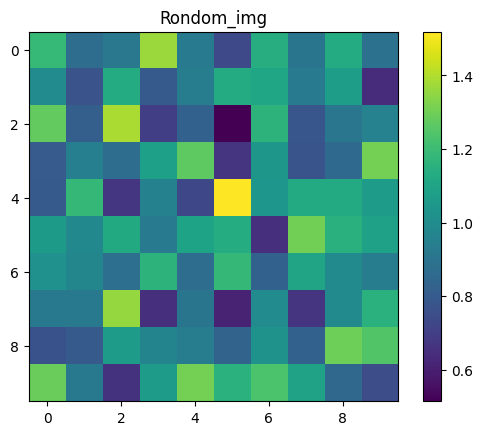

In [62]:
# check the generator output is of the right type and shape

epochs=1000
v_dim = 2*10*10
z_dim = 40
h_dim=500

class_num=len(T)

model_G = Generator(v_dim=v_dim, h_dim=h_dim,z_dim=z_dim, learning_rate=1e-4, class_num=50)
# move model to cuda device
model_G.to(device)

Random_label=generate_random_one_hot(1,class_num)

output = model_G.forward(generate_random_seed(1,z_dim), Random_label)

img = output.detach().cpu().numpy().reshape(2,10,10)

plt.imshow(img.sum(axis=0))#, interpolation='none', cmap='Blues'\
plt.title('Rondom_img')
plt.colorbar()

## Train GAN

In [63]:
%%time 
v_dim = 2*10*10
z_dim = 50#100#25#120
h_dim=500
learning_rate=5e-4
epochs = 300
class_num = 50

# create Discriminator and Generator

D_model = Discriminator(v_dim=v_dim,  h_dim=h_dim, z_dim=z_dim, learning_rate=learning_rate, class_num=class_num)
D_model.to(device)
G_model = Generator(v_dim=v_dim,  h_dim=h_dim+500, z_dim=z_dim, learning_rate=learning_rate, class_num=class_num)
G_model.to(device)#+200


D_losses = []
G_losses = []

for epoch in np.arange(epochs):
    # print ("epoch = ", epoch + 1)
    d_losses=0
    g_losses=0

    # train Discriminator and Generator

    for image_data_tensor, label_tensor in data_loader:#data_set
    # train discriminator on true
        image_data_tensor = image_data_tensor.view(-1, v_dim)#torch.flatten(image_data_tensor)#, start_dim=1
    
        D_model.train(image_data_tensor, label_tensor, torch.ones(batch_size,1))#torch.cuda.FloatTensor([1.0])
        d_losses += D_model.Loss.detach().item()
    # random_label=generate_random_one_hot(51)

        Genetated_random_hot=generate_random_one_hot(batch_size, class_num)
    
    # train discriminator on false
    
    # use detach() so gradients in G are not calculated
        D_model.train(G_model.forward(generate_random_seed(batch_size,z_dim), Genetated_random_hot).detach(), Genetated_random_hot, torch.zeros(batch_size,1))#torch.cuda.FloatTensor([0.0])
        d_losses += D_model.Loss.detach().item()

        Genetated_random_hot=generate_random_one_hot(batch_size, class_num)

    # # train generator
        G_model.train(D_model, generate_random_seed(batch_size,z_dim), Genetated_random_hot, torch.ones(batch_size,1))#torch.cuda.FloatTensor([1.0])
        g_losses += G_model.Loss.detach().item()
    
    if (epoch+1)%10==0:
        print('Epoch: {}, D_loss: {}, G_loss: {}'.format(epoch+1, d_losses / (2*len(data_loader)),g_losses / len(data_loader)))

    D_losses.append(d_losses / (2*len(data_loader)))
    G_losses.append(g_losses / len(data_loader))

Epoch: 10, D_loss: 0.06274514901015209, G_loss: 5.519373360276222
Epoch: 20, D_loss: 0.14199961077902118, G_loss: 4.883921694755554
Epoch: 30, D_loss: 0.19318223866866902, G_loss: 4.53666128218174
Epoch: 40, D_loss: 0.5494739150628447, G_loss: 1.6110494866967202
Epoch: 50, D_loss: 0.613155628181994, G_loss: 1.1783590331673621
Epoch: 60, D_loss: 0.6273808414116502, G_loss: 1.1367130279541016
Epoch: 70, D_loss: 0.6296677574515342, G_loss: 1.123087900876999
Epoch: 80, D_loss: 0.6183475859463214, G_loss: 1.3562710508704185
Epoch: 90, D_loss: 0.6207447500899435, G_loss: 1.1609167970716954
Epoch: 100, D_loss: 0.6010456521064043, G_loss: 1.1941441245377065
Epoch: 110, D_loss: 0.6024267578497529, G_loss: 1.2648777596652507
Epoch: 120, D_loss: 0.5731971222907305, G_loss: 1.380887146294117
Epoch: 130, D_loss: 0.5880736930295825, G_loss: 1.2742341175675391
Epoch: 140, D_loss: 0.6035356659442186, G_loss: 1.263336469233036
Epoch: 150, D_loss: 0.6031603839248418, G_loss: 1.2210144013166429
Epoch: 16

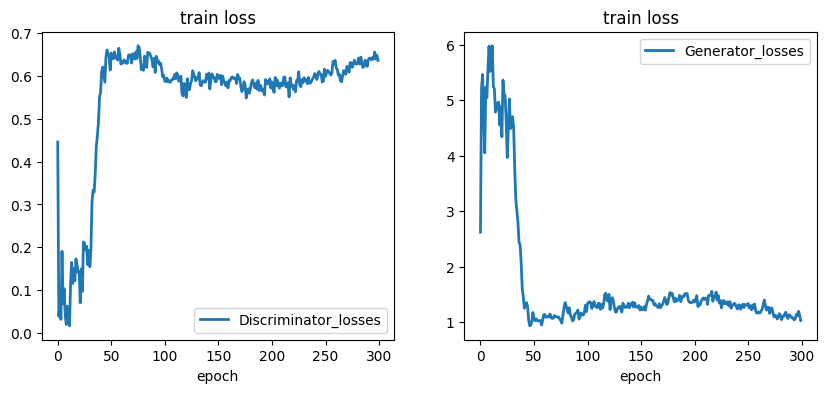

In [66]:
# plot discriminator error

fig = plt.figure(figsize=(10,4))
ax1=plt.subplot(121)
ax1.set_title('train loss')
ax1.plot(np.arange(len(D_losses)), D_losses, linewidth=2, linestyle='-', label='Discriminator_losses')
ax1.set_xlabel('epoch')
ax1.legend()

ax2=plt.subplot(122)
ax2.set_title('train loss')
ax2.plot(np.arange(len(G_losses)), G_losses, linewidth=2, linestyle='-', label='Generator_losses')
ax2.set_xlabel('epoch')
ax2.legend()

plt.show()

## Run trained GAN

[ 0.79144365 -0.56056577]


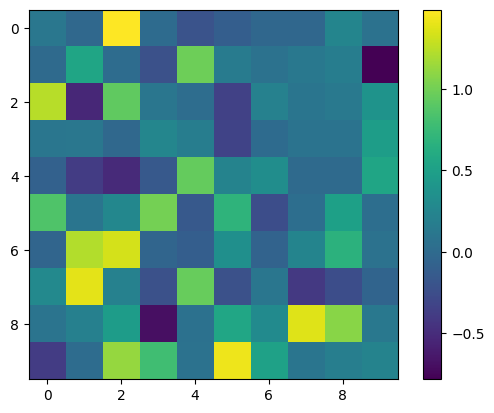

In [75]:
Temperature=10
Code=torch.zeros(50)
Code[Temperature-1]=1.0
output=G_model.forward(generate_random_seed(1,z_dim), Code.reshape(1,50))
img = output.detach().cpu().numpy().reshape(2,10,10)
generated_img=img*2-1
plt.imshow(generated_img.sum(axis=0))
plt.colorbar()

print(generated_img.sum(axis=1).sum(axis=1)/100)

## Generator create data for magnetic measurement

In [88]:
M_generated=[]
Susceptibility = []

sample_num=400
for ii in range(0,len(T)):
    Code=torch.zeros(50)
    Code[ii]=1.0

    cal_M = 0
    cal_M_2=0
    # cal_E = 0
    # cal_E_2 = 0
    for jj in range(sample_num):
        output=G_model.forward(generate_random_seed(1,z_dim), Code.reshape(1,50))
        img = output.detach().cpu().numpy().reshape(2,10,10)
        generated_img=img*2-1

        cal_M += generated_img.sum()/100
        cal_M_2 += (generated_img.sum()/100)**2


    cal_M = cal_M/sample_num
    cal_M_2 = cal_M_2/sample_num

    # E.append(copy.deepcopy(cal_M))
    # Cv.append(copy.deepcopy((1/(ii+1)**2)*(cal_E_2 - cal_E**2)))

    M_generated.append(cal_M.copy())
    Susceptibility.append(((1/(ii+1))*(cal_M_2-cal_M**2)))


M_generated=np.array(M_generated)
Susceptibility=np.array(Susceptibility)

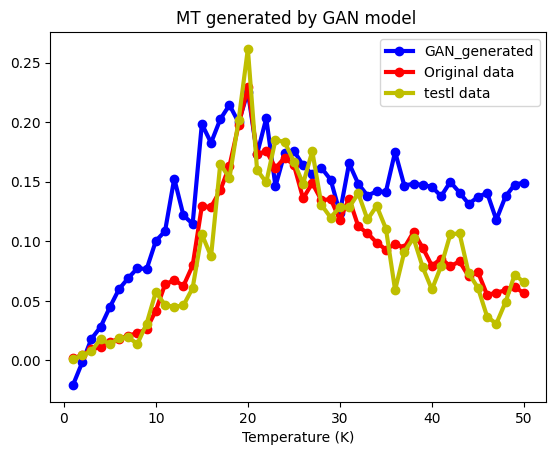

In [89]:
plt.plot(T, M_generated,'bo-',markersize=6,lw=3,label='GAN_generated')
plt.plot(T, M_raw,'ro-',markersize=6,lw=3,label='Original data')
plt.plot(T, M_raw_test,'yo-',markersize=6,lw=3,label='testl data')

plt.title('MT generated by GAN model ')
plt.xlabel('Temperature (K)')
plt.legend()
plt.show()

Text(0.5, 0, 'Temperature (K)')

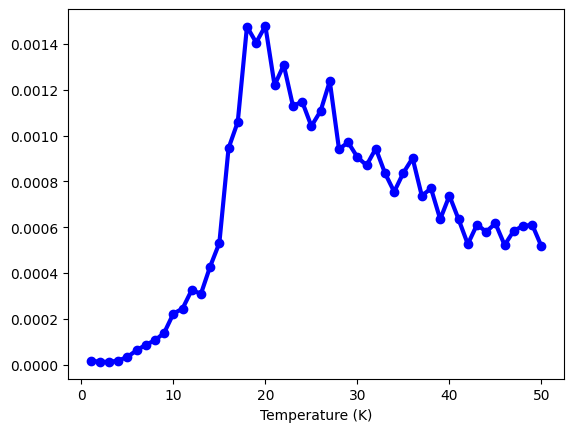

In [82]:
plt.plot(T, Susceptibility,'bo-',markersize=6,lw=3)
plt.xlabel('Temperature (K)')

## Model saving and reloading

In [84]:
torch.save(G_model,"Trained_model_saving/G_z50_h5001000_Ir4em5.pth")# 
torch.save(D_model,"Trained_model_saving/D_z50_h5001000_Ir4em5.pth")# saving the whole model

In [85]:
reloaded_G=torch.load("Trained_model_saving/G_z50_h5001000_Ir4em5.pth")
reloaded_D=torch.load("Trained_model_saving/D_z50_h5001000_Ir4em5.pth")

## Continue Training the reload model

In [98]:
re_epochs = 2#300
class_num = len(T)
reD_losses = []
reG_losses = []

for epoch in range(re_epochs):

    d_loss=0
    g_loss=0

    for image_data_tensor, label_tensor in data_loader:#data_set
    # train discriminator on true
        image_data_tensor = image_data_tensor.view(-1, v_dim)#torch.flatten(image_data_tensor)#, start_dim=1
    
        reloaded_D.train(image_data_tensor, label_tensor, torch.ones(batch_size,1))#torch.cuda.FloatTensor([1.0])
        d_loss += reloaded_D.Loss.detach().item()
    # random_label=generate_random_one_hot(51)

        Genetated_random_hot=generate_random_one_hot(batch_size, class_num)
    
    # train discriminator on false
    
    # use detach() so gradients in G are not calculated
        reloaded_D.train(reloaded_G.forward(generate_random_seed(batch_size,z_dim), Genetated_random_hot).detach(), Genetated_random_hot, torch.zeros(batch_size,1))#torch.cuda.FloatTensor([0.0])
        d_loss += reloaded_D.Loss.detach().item()

        Genetated_random_hot=generate_random_one_hot(batch_size, class_num)

    # # train generator
        reloaded_G.train(reloaded_D, generate_random_seed(batch_size,z_dim), Genetated_random_hot, torch.ones(batch_size,1))#torch.cuda.FloatTensor([1.0])
        g_loss += reloaded_G.Loss.detach().item()
    
    if (epoch+1)%1==0:
        print('Epoch: {}, D_loss: {}, G_loss: {}'.format(epoch+1, d_loss / (2*len(data_loader)),g_loss / len(data_loader)))


    reD_losses.append(d_loss / (2*len(data_loader)))
    reG_losses.append(g_loss / len(data_loader))

Epoch: 1, D_loss: 0.6369140561670065, G_loss: 1.100287889689207
Epoch: 2, D_loss: 0.6467006389051676, G_loss: 1.1364631697535514


In [99]:
M_regenerated=[]
reSusceptibility = []

sample_num=400
for ii in range(0,len(T)):
    Code=torch.zeros(50)
    Code[ii]=1.0

    cal_M = 0
    cal_M_2=0

    for jj in range(sample_num):
        output=reloaded_G.forward(generate_random_seed(1,z_dim), Code.reshape(1,50))
        img = output.detach().cpu().numpy().reshape(2,10,10)
        generated_img=img*2-1

        cal_M += generated_img.sum()/100
        cal_M_2 += (generated_img.sum()/100)**2


    cal_M = cal_M/sample_num
    cal_M_2 = cal_M_2/sample_num

    M_regenerated.append(cal_M.copy())
    reSusceptibility.append(((1/(ii+1))*(cal_M_2-cal_M**2)))


M_regenerated=np.array(M_regenerated)
reSusceptibility=np.array(reSusceptibility)

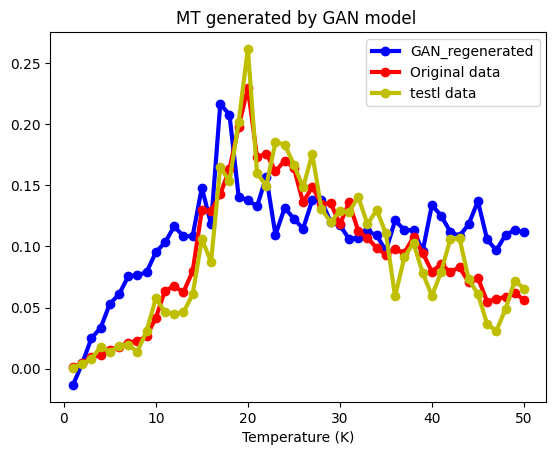

In [100]:
plt.plot(T, M_regenerated,'bo-',markersize=6,lw=3,label='GAN_regenerated')
plt.plot(T, M_raw,'ro-',markersize=6,lw=3,label='Original data')
plt.plot(T, M_raw_test,'yo-',markersize=6,lw=3,label='testl data')

plt.title('MT generated by GAN model ')
plt.xlabel('Temperature (K)')
plt.legend()
plt.show()